In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher

In [2]:
#This function uses regular expressions to do three things:
#    1. replace URLs starting with https:// (like the links posted in many suggestions) with a space
#    2. replace non-necessary charcaters with spaces. These are more often used for post formatting than titles, but can get in the way of detecting titles
#    3. remove apostrohpes - do not replace with space. People are lazy with apostrophes and often forget them, or put them in the wrong places.

def simplify_text(s):
    return re.sub('[\'\\u2019\\u0027]', '', re.sub('[^a-zA-Z0-9:;.,&$!?\'\\u2019]', ' ', re.sub('https://[=?\-_./\w]+', ' ', s)))

In [3]:
#This function takes a list of strings and makes them one string separated by '%' character
#This is used to apply() to the suggested title ids column for easy splitting in other notebooks

def list_to_string(s_list):
    s_str = ''

    for text in s_list:
        s_str += text + "%"
        
    if len(s_str) == 0:
        return np.nan
    
    return s_str[:-1]

In [4]:
def get_matches(doc, debug = False):
    m_list = []
    to_remove = []
    
    matches = matcher(doc)
    
    if debug:
        print(doc.text)

    for i, match in enumerate(matches):
        m_start = match[1]
        m_end = match[2]
        m_list.append((m_start, m_end))
        
        if debug:
            print(match)
            print(doc[m_start : m_end], end = ' ')
            
        #This code block removes false positives of movie titles that appear within other movie titles
        #For example, "The Mask" would appear in "Son of The Mask" but the latter would be the true recommendation

        if(len(m_list) > 1):
            if m_list[-1][0] >= m_list[-2][0] and m_list[-1][0] <= m_list[-2][1]:
                if abs(m_list[-1][1] - m_list[-1][0]) > abs(m_list[-2][1]-m_list[-2][0]):
                    if debug:
                        print("REMOVE ABOVE", end ='')
                    to_remove.append(i-1)
                else:
                    if debug:
                        print("REMOVE THIS", end = '')
                    to_remove.append(i)

        if debug:
            print('')

    #starting at the last index, remove each item in to_remove from matches
    for i in to_remove[::-1]:
        matches.pop(i)

    return matches

---

In [5]:
nlp = spacy.load('en_core_web_lg')
nlp.remove_pipe('ner')

('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1bb5ba51768>)

In [6]:
movies = pd.read_csv('./movies_data/movies.csv')
requests = pd.read_csv('./movies_data/slow_df.csv')
comments = pd.read_csv('./movies_data/slow_comments.csv')

In [ ]:
requests.head()

In [ ]:
comments.head()

# Movies Dataframe and Dictionaries

In [9]:
movies

,id,titles,primary_title,year,rating,num_votes
0,tt0004972,The Birth of the Nation; Or The Clansman%In th...,The Birth of a Nation,1915,6.3,22280
1,tt0006864,Intolerance: Love's Struggle Throughout the Ag...,Intolerance: Love's Struggle Throughout the Ages,1916,7.7,13915
2,tt0009611,Shoulder Arms,Shoulder Arms,1918,7.3,5922
3,tt0009968,Broken Blossoms or The Yellow Man and the Girl...,Broken Blossoms,1919,7.3,9263
4,tt0010323,Das Cabinet des Dr. Caligari%The Cabinet of Dr...,The Cabinet of Dr. Caligari,1920,8.1,55789
...,...,...,...,...,...,...
11850,tt9817070,Just 6.5%Metri Shesh Va Nim,Just 6.5,2019,7.9,5787
11851,tt9860728,Falling Inn Love,Falling Inn Love,2019,5.6,14273
11852,tt9877170,Malang%Malang - Unleash the Madness,Malang,2020,6.5,7204
11853,tt9898858,Coffee & Kareem,Coffee & Kareem,2020,5.1,10743


In [7]:
titles_list = []
titles_lower = []
ids_list = []

for i, titles in enumerate(list(movies['titles'])):
    split_titles = titles.split('%')
    titles_list += split_titles
    
    for _ in range(len(split_titles)):
        ids_list.append(movies['id'][i])
    
for title in titles_list:
    titles_lower.append(simplify_text(title).lower())

For now, the system will return only the most recent movie when multiple movies share the same name. Further down the road, one goal may be to identify different movies with the same name (when possible) such as '101 Dalmations' 1961 or 1996. When comments include the year this will be possible, though it may not be easy. However, I will prepare the dictionaries with title years now for use later.

In [8]:
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
name_dict = {titles_lower[i] : ids_list[i] for i in range(len(titles_lower))}
title_dict = {ids_list[i] : titles_list[i] for i in range(len(titles_lower))}

name_dict_with_dups = {}

for i in range(len(titles_lower)-1, -1, -1):
    # https://stackoverflow.com/a/18552025
    if titles_lower[i] in list(name_dict_with_dups):
        name_dict_with_dups[titles_lower[i] + ' ' + str(movies[movies['id'] == ids_list[i]]['year'].values[0])] = ids_list[i]
    else:
        name_dict_with_dups[titles_lower[i]] = ids_list[i]
        

name_dict_dups_only = {i : name_dict_with_dups[i] for i in list(name_dict_with_dups) if i not in list(name_dict)}

# ----

In [9]:
patterns = [nlp.make_doc(text) for text in titles_lower]

matcher = PhraseMatcher(nlp.vocab)
matcher.add("MovieTitles", None, *patterns)

In [10]:
#Only get top-level comments: those comments whose "parent" is the submission, not another comment
comments = comments[comments['parent_id'] == comments['link_id']]
comments.reset_index(inplace=True)

In [11]:
comments_simple = comments.copy()
comments_simple['body'] = comments_simple['body'].apply(simplify_text)


---

In [12]:
# There is a bot that compiles reccomendations. That could be very useful for me! But for now, I need to ignore it. Later, I can compare what movies I found to what the bot found.
# author = 'cinephilebot'
flag = '   Replying after taking permission from mod'

ignore_list = []

for i, comment in enumerate(comments_simple['body']):
    if flag == comment[:len(flag)]:
        ignore_list.append(i)

matched_title = com1[matches[0][1] : matches[0][2]]

movies[movies.id == name_dict[matched_title.text]]

In [13]:
# A little more cleaning to get ready to make the new dataframe: requests + suggestions

#Drop any comments by the requester
comments_simple = comments_simple[comments_simple['is_submitter'] == False]

#format the links for comparison to requests
comments_simple['link_id'] = comments_simple['link_id'].str[3:]

comments_simple = comments_simple[['author', 'score', 'body', 'link_id', 'is_submitter']]

#Drop the rows that are not flaired as requests
requests = requests[requests['link_flair_css_class'] == 'request']

requests = requests[['id', 'created_utc', 'title', 'selftext']]

In [14]:
suggestions = pd.DataFrame(columns = ['title', 'selftext', 'movie_ids'])
suggestions

,title,selftext,movie_ids


In [15]:
comments_simple

,author,score,body,link_id,is_submitter
0,ImAK93,1,I See You 2019,iyq8s5,False
1,MatiasMus,1,"Hopefully youve already seen this, but Coming ...",iyyt03,False
2,bookslove79,1,Sorry!! I couldnt read the whole replies But ...,iyscw5,False
3,sassytrainwreck,1,Under the Tuscan Sun is one of my faves.,iyx448,False
4,Truthisnotallowed,1,Crime comedies: Topkapi 1964 That Ma...,iyz3e7,False
...,...,...,...,...,...
93485,scabcoat,1,500 Days of Summer When We First Met For...,cb4lsu,False
93486,jupiterkansas,1,The Remains of the Day,cb4lsu,False
93487,nsharer84,1,Spanglish. God I loved that movie.,cb4lsu,False
93488,ewieranga,1,Evolution 2018 or Idiocracy 2006,cb49fc,False


In [428]:
#Create a dictionary with keys = request posts, and values = list of suggestions by commenters

#POSSIBLE CHANGES:
#   1. make a list of tuples instead of strings, each tuple containing a suggested title_ID and post score - to find quality suggestions or rank suggestions
#   2. narrow down the comments by only taking the top X, or using a higher value on the score filter

sugg_dict = {link_id : [] for link_id in requests['id']}
sugg_scores_dict = {link_id : [] for link_id in requests['id']}

counter = 0
total_len = comments_simple.shape[0]

for i in comments_simple.index:
    row = comments_simple[comments_simple.index == i]
    if (row['score'].values[0] <= 0 ) or (i in ignore_list):
        continue
    
    body = nlp(row['body'].values[0].lower())
    link_id = row['link_id'].values[0]
    
    matches = get_matches(body)
    
    for match in matches:
        matched_title = body[match[1] : match[2]]
        try:
            sugg_dict[link_id].append(name_dict[matched_title.text])
            sugg_scores_dict[link_id].append((name_dict[matched_title.text], row['score'].values[0]))
        except:
            #print(f"Failed match: {matched_title.text}, comment index {i}")
            pass
    
    counter += 1
    if counter % int(total_len/20) == 0:
        print(f'{int(100 * counter/total_len)}%   ', end = '')

4%   9%   14%   19%   24%   29%   34%   39%   44%   49%   54%   59%   64%   69%   74%   79%   84%   89%   94%   

In [429]:
# Examining the results:

count = 0
zero_count = 0
sugg_sum = 0
uniq_sum = 0
max_sugg = 0
max_uniq = 0

for i in sugg_dict:
    count += 1
    sugg_list = sugg_dict[i]
    list_len = len(sugg_list)
    uniq_len = len(set(sugg_list))
    uniq_sum += uniq_len
    sugg_sum += list_len
    
    if list_len == 0:
        zero_count += 1
        
    if list_len > max_sugg:
        max_sugg = list_len
        max_uniq = uniq_len
    
print(f"There are an average of {round(sugg_sum/count, 1)} suggestions per request.")
print(f"There are an average of {round(uniq_sum/count, 1)} unique suggestions per request.")
print(f"Overall, there were a total of {count} requests and {uniq_sum} unique suggestions.\n")
print(f"Out of {count} requests, {zero_count} ({np.round(100*zero_count/count,1)}%) had 0 suggestions (that were found).")
print(f"Of those requests that had > 0 suggestions, there were an average of {round(uniq_sum/(count-zero_count), 1)} unique suggestions.\n")
print(f"The request with the most suggestions had {max_sugg} suggestions, or {round(100 * max_sugg/sugg_sum, 2)}% of the total, {max_uniq} of which were unique. ({round(100 * max_uniq / uniq_sum,2)}% of total)")

There are an average of 20.7 suggestions per request.
There are an average of 16.7 unique suggestions per request.
Overall, there were a total of 11329 requests and 188964 unique suggestions.

Out of 11329 requests, 2643 (23.3%) had 0 suggestions (that were found).
Of those requests that had > 0 suggestions, there were an average of 21.8 unique suggestions.

The request with the most suggestions had 2682 suggestions, or 1.14% of the total, 947 of which were unique. (0.5% of total)


In [432]:
# cast the list to a set, and back to a list, to remove duplicate suggestions

idx_list = []
sugg_list_list = []

for i in sugg_dict:
    sugg_dict[i] = list(set(sugg_dict[i]))
    idx_list.append(i)
    sugg_list_list.append(sugg_dict[i])

In [433]:
# Remove duplicates from sugg_scores_dict, keeping only the highest recorded score

sugg_scores_nodup = {}

for i in sugg_scores_dict:
    tups = {}
    
    for tt_id, score in (sugg_scores_dict[i]):
        if tt_id in tups:
            if tups[tt_id] < score:
                tups[tt_id] = score
            else:
                pass
        else:
            tups[tt_id] = score
    
    sugg_scores_nodup[i] = tups       

In [434]:
post_id = requests[55:56]['id'].values[0]
comments_simple[comments_simple['link_id'] == post_id]

,author,score,body,link_id,is_submitter
122,Nativeferment,1,One movie that stands out for composition is I...,ixgrvu,False
157,Jamezone,1,Speedracer,ixgrvu,False


In [435]:
sugg_df = pd.DataFrame(columns= ['id', 'suggestions'])
sugg_df['id'] = idx_list
sugg_df['suggestions'] = sugg_list_list

requests_with_suggestions = requests.merge(right = sugg_df, left_on = 'id', right_on = 'id')

In [436]:
requests_with_suggestions.head()

,id,created_utc,title,selftext,suggestions
0,iyzb2g,1600961198,Gay romantic film with an engaging plot.,Not asking for something very deep or slow pac...,[]
1,iyz81n,1600960931,FIRST TIME HAVING NETLIX!,Need to fill up My List! I enjoy edge of your...,"[tt1734493, tt4263482, tt0457430, tt4846232, t..."
2,iyz3e7,1600960479,Movies where main characters are or become cri...,basically I want a fun movie to kill time with...,"[tt0317248, tt0119396, tt0048021, tt0087803, t..."
3,iyyt03,1600959529,Looking for movies which are fun and not too s...,Hey! I am looking for movie recommendations wh...,"[tt0094898, tt2294449, tt1232829, tt1187043, t..."
4,iyyjk1,1600958640,All sherlock holmes movies and tv shows,Looking for all the sherlock holmes movies and...,"[tt0091223, tt0047573, tt0090357, tt0087803]"


In [437]:
# create a 'scores' row that lists the scores for each suggestion, in the same order in which the suggestions themselves are stores

scores_list = []

x = 0

sugg_col = requests_with_suggestions['suggestions']

for row_id in requests_with_suggestions['id']:
    score_str = ''
    for sugg in sugg_col[x]:
        score_str += str(sugg_scores_nodup[row_id][sugg]) + ','
        
    scores_list.append(score_str[:-1])
    
    x += 1
    
requests_with_suggestions['scores'] = scores_list

In [438]:
requests_with_suggestions.head()

,id,created_utc,title,selftext,suggestions,scores
0,iyzb2g,1600961198,Gay romantic film with an engaging plot.,Not asking for something very deep or slow pac...,[],
1,iyz81n,1600960931,FIRST TIME HAVING NETLIX!,Need to fill up My List! I enjoy edge of your...,"[tt1734493, tt4263482, tt0457430, tt4846232, t...","1,1,1,1,1,1,1,1,1,1,1,1,1"
2,iyz3e7,1600960479,Movies where main characters are or become cri...,basically I want a fun movie to kill time with...,"[tt0317248, tt0119396, tt0048021, tt0087803, t...","1,2,2,1,2,1,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,1,..."
3,iyyt03,1600959529,Looking for movies which are fun and not too s...,Hey! I am looking for movie recommendations wh...,"[tt0094898, tt2294449, tt1232829, tt1187043, t...","1,1,1,1,1,1,1,1,1,1,1,1"
4,iyyjk1,1600958640,All sherlock holmes movies and tv shows,Looking for all the sherlock holmes movies and...,"[tt0091223, tt0047573, tt0090357, tt0087803]","1,1,1,1"


In [439]:
requests_with_suggestions['suggestions'] = requests_with_suggestions['suggestions'].apply(list_to_string)

In [440]:
requests_with_suggestions['suggestions']

0                                                      NaN
1        tt1734493%tt4263482%tt0457430%tt4846232%tt0443...
2        tt0317248%tt0119396%tt0048021%tt0087803%tt2872...
3        tt0094898%tt2294449%tt1232829%tt1187043%tt0120...
4                  tt0091223%tt0047573%tt0090357%tt0087803
                               ...                        
11324                                                  NaN
11325                                                  NaN
11326                                                  NaN
11327                                                  NaN
11328                                                  NaN
Name: suggestions, Length: 11329, dtype: object

In [441]:
requests_with_suggestions['selftext'] = requests_with_suggestions['selftext'].astype(str)

In [442]:
(requests_with_suggestions['selftext'] == 'nan').value_counts()

False    9729
True     1600
Name: selftext, dtype: int64

In [443]:
#Drop all rows without suggestions
requests_with_suggestions.dropna(inplace=True)

In [444]:
requests_with_suggestions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8686 entries, 1 to 11318
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8686 non-null   object
 1   created_utc  8686 non-null   int64 
 2   title        8686 non-null   object
 3   selftext     8686 non-null   object
 4   suggestions  8686 non-null   object
 5   scores       8686 non-null   object
dtypes: int64(1), object(5)
memory usage: 475.0+ KB


In [445]:
requests_with_suggestions.head()

,id,created_utc,title,selftext,suggestions,scores
1,iyz81n,1600960931,FIRST TIME HAVING NETLIX!,Need to fill up My List! I enjoy edge of your...,tt1734493%tt4263482%tt0457430%tt4846232%tt0443...,"1,1,1,1,1,1,1,1,1,1,1,1,1"
2,iyz3e7,1600960479,Movies where main characters are or become cri...,basically I want a fun movie to kill time with...,tt0317248%tt0119396%tt0048021%tt0087803%tt2872...,"1,2,2,1,2,1,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,1,..."
3,iyyt03,1600959529,Looking for movies which are fun and not too s...,Hey! I am looking for movie recommendations wh...,tt0094898%tt2294449%tt1232829%tt1187043%tt0120...,"1,1,1,1,1,1,1,1,1,1,1,1"
4,iyyjk1,1600958640,All sherlock holmes movies and tv shows,Looking for all the sherlock holmes movies and...,tt0091223%tt0047573%tt0090357%tt0087803,"1,1,1,1"
5,iyxzfg,1600956699,"Films with supportive couples or families, ant...",Fairly newish to Reddit so apologies if postin...,tt0272020,1


In [446]:
requests_with_suggestions.to_csv('./movies_data/requests_with_suggestions.csv', index = False)

----

The following code is designed to find those titles that are severely overrepresented in the suggestions - because they are one-word titles that are very common words.

In [151]:
title_suggestions = {tt_id : 0 for tt_id in movies['id']}

for sugg_list in sugg_list_list:
    for sugg in sugg_list:
        title_suggestions[sugg] += 1

In [152]:
title_votes = dict(zip(movies['id'], movies['num_votes']))

In [197]:
titles_df = pd.DataFrame(data = title_suggestions.values(), index = title_suggestions.keys(), columns=['suggestions'])

titles_df['votes'] = title_votes.values()

titles_df = titles_df[titles_df['suggestions'] > 0]

sugg_max = max(titles_df['suggestions'])
vote_max = max(titles_df['votes'])
titles_df['suggestions'] = titles_df['suggestions'].apply(lambda x : x / sugg_max)
titles_df['votes'] = titles_df['votes'].apply(lambda x : x / vote_max)
titles_df['title'] = titles_df.index.map(lambda s : title_dict[s]).values #https://stackoverflow.com/questions/20025325/apply-function-on-dataframe-index
titles_df = titles_df.sort_values(by = 'votes', ascending = False)

titles_df['difference'] = titles_df['votes'] - titles_df['suggestions']

C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


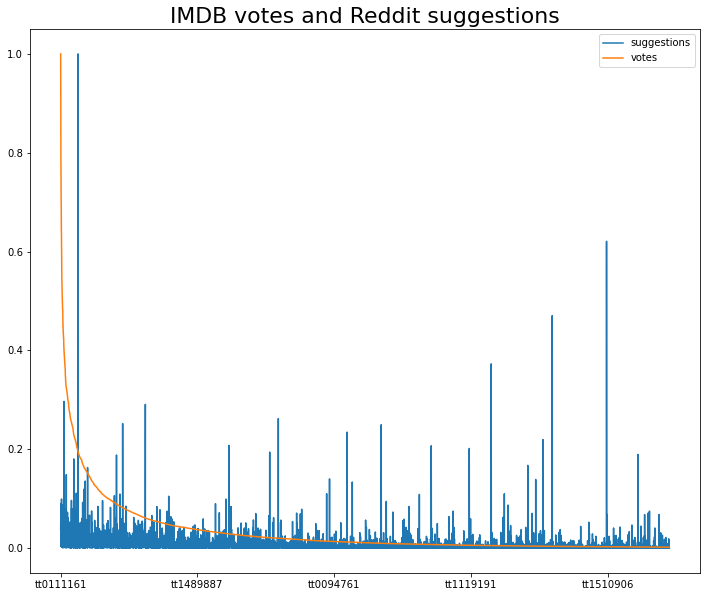

In [214]:
titles_df[['suggestions', 'votes']].plot(figsize = (12,10))
plt.title("IMDB votes and Reddit suggestions", fontsize = 22);

In [410]:
titles_df.sort_values(by = 'difference', ascending = True)[:5]

,suggestions,votes,title,difference
tt1396484,1.000000,0.194412,It,-0.805588
tt0436364,0.620830,0.002968,Good,-0.617862
tt4298958,0.470572,0.003886,Sweet Bean,-0.466686
tt0283632,0.372932,0.005343,Wes Craven Presents: They,-0.367589
tt3774694,0.262273,0.020191,Love,-0.242082


In [412]:
problem_titles = movies[movies['id'].isin(titles_df[titles_df['difference'] < 0 - titles_df['difference'].std()].index.values)]

problem_titles['titles'] = problem_titles['titles'].str.split("%")

titles_list = problem_titles['titles']

C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [413]:
to_keep = ['DASturb', 'Dracula', 'Maqbool', 'Masti', 'Ils', 'So-won', 'Te3n']

for titles in titles_list:
    to_remove = []
    for title in titles:
        if ' ' not in title and title not in to_keep or title == 'The Other':
            to_remove.append(title)
    for rmv in to_remove:
        titles.remove(rmv)


In [414]:
def set_to_str(strset):
    titles_string = ''
    while True:
        try:
            titles_string += strset.pop() + '%'
        except:
            break
    
    titles_string = titles_string[:-1]
    return titles_string

In [415]:
corrections = problem_titles[['id', 'titles']].copy()

corrections['titles'] = corrections['titles'].apply(set_to_str)

corrections.to_csv('movies_data/title_corrections.csv', index = False)